In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# 데이터 로드
data = pd.read_csv('../document/filter_ship.csv')



# 필요 없는 열 제거
filtered_data = data.drop(columns=['id', 'msg_type', 'mmsi', 'status', 'created_at', 'datetime'])

# 타겟 변수와 독립 변수
target_columns = ['lat', 'lon']  # 타겟 변수
independent_columns = list(filtered_data.columns)  # 모든 열을 독립변수로 포함

# 타겟 변수 스케일링
scaler = StandardScaler()
filtered_data[target_columns] = scaler.fit_transform(filtered_data[target_columns])

# 시계열 데이터 변환
time_steps = 5
X, y = [], []
for i in range(len(filtered_data) - time_steps):
    # 입력 데이터: 모든 독립변수 포함
    X.append(filtered_data.iloc[i:i+time_steps][target_columns].values)
    # 출력 데이터: 타겟 변수만 포함
    y.append(filtered_data.iloc[i+time_steps][target_columns].values)
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print(f"X 크기: {X.shape}, y 크기: {y.shape}")



Using device: cuda
X 크기: (36824, 5, 2), y 크기: (36824, 2)


In [5]:
# 데이터 분할 (학습/테스트만 나누기)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (29459, 5, 2), (29459, 2)
Test 데이터 크기: (7365, 5, 2), (7365, 2)


In [6]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [8]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0249
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0333
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0249
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.0280
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.5424
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0068
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0283
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 0.0140


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0521
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 64}, Loss: 0.0945
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 128}, Loss: 0.8171
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.0600
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0094
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0153
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 1.0686
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0183
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_s

In [7]:
# import itertools
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import ParameterGrid

# # LSTM 모델 정의
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
#         return out

# # 하이퍼파라미터 그리드 정의
# param_grid = {
#     'hidden_size': [64, 128, 256, 512],          # 은닉 상태 크기
#     'num_layers': [1, 2, 3, 4],                 # LSTM 레이어 수
#     'learning_rate': [0.0001, 0.001, 0.01],     # 학습률
#     'batch_size': [16, 32, 64, 128],                 # 배치 크기
#     'dropout': [0.0, 0.2, 0.5]                  # 드롭아웃 비율
# }

# # 모든 조합 생성
# param_combinations = list(ParameterGrid(param_grid))

# # 그리드 서치 실행
# best_loss = float('inf')
# best_params = None

# for params in param_combinations:
#     hidden_size = params['hidden_size']
#     num_layers = params['num_layers']
#     learning_rate = params['learning_rate']
#     batch_size = params['batch_size']
#     dropout = params['dropout']

#     # 모델 초기화
#     model = LSTMModel(
#         input_size=X_train.shape[2],
#         hidden_size=hidden_size,
#         num_layers=num_layers,
#         output_size=2,  # lat, lon
#         dropout=dropout
#     ).to(device)

#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # 배치 학습
#     model.train()
#     train_loss = 0.0
#     for i in range(0, len(X_train_tensor), batch_size):
#         X_batch = X_train_tensor[i:i+batch_size]
#         y_batch = y_train_tensor[i:i+batch_size]

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     # 평균 손실 계산
#     avg_loss = train_loss / (len(X_train_tensor) // batch_size)
#     print(f"Params: {params}, Loss: {avg_loss:.4f}")

#     # 최적 파라미터 저장
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         best_params = params

# print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 1}, Loss: 0.1673
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 2}, Loss: 0.1138
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 3}, Loss: 0.1258
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 4}, Loss: 0.1383
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 1}, Loss: 0.0208
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 2}, Loss: 0.0198
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 3}, Loss: 0.0202
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 4}, Loss: 0.0171
Params: {'batch_size': 16, 'dropout': 0.0, 'hidden_size': 64

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 1}, Loss: 0.1692
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 2}, Loss: 0.1192
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 3}, Loss: 0.1387
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 4}, Loss: 0.1408
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 1}, Loss: 0.0203
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 2}, Loss: 0.0200
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 3}, Loss: 0.0189
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 4}, Loss: 0.0219
Params: {'batch_size': 16, 'dropout': 0.2, 'hidden_size': 64

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 1}, Loss: 0.1640
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 2}, Loss: 0.1390
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 3}, Loss: 0.1568
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.0001, 'num_layers': 4}, Loss: 0.1512
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 1}, Loss: 0.0229
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 2}, Loss: 0.0206
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 3}, Loss: 0.0193
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 4}, Loss: 0.0215
Params: {'batch_size': 16, 'dropout': 0.5, 'hidden_size': 64

KeyboardInterrupt: 

In [11]:
# # 학습 루프
# num_epochs = 100
# train_loss_list = []

# best_model.train()
# for epoch in range(num_epochs):
#     train_loss = 0.0
#     for i in range(0, len(X_train_tensor), best_params['batch_size']):
#         X_batch = X_train_tensor[i:i+best_params['batch_size']]
#         y_batch = y_train_tensor[i:i+best_params['batch_size']]

#         optimizer.zero_grad()
#         outputs = best_model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     avg_train_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/100], Loss: 0.0035
Epoch [2/100], Loss: 0.0079
Epoch [3/100], Loss: 0.0104
Epoch [4/100], Loss: 0.0110
Epoch [5/100], Loss: 0.0143
Epoch [6/100], Loss: 0.0116
Epoch [7/100], Loss: 0.0120
Epoch [8/100], Loss: 0.0128
Epoch [9/100], Loss: 0.0173
Epoch [10/100], Loss: 0.0136
Epoch [11/100], Loss: 0.0070
Epoch [12/100], Loss: 0.0105
Epoch [13/100], Loss: 0.0110
Epoch [14/100], Loss: 0.0111
Epoch [15/100], Loss: 0.0111
Epoch [16/100], Loss: 0.0110
Epoch [17/100], Loss: 0.0112
Epoch [18/100], Loss: 0.0112
Epoch [19/100], Loss: 0.0112
Epoch [20/100], Loss: 0.0106
Epoch [21/100], Loss: 0.0103
Epoch [22/100], Loss: 0.0109
Epoch [23/100], Loss: 0.0111
Epoch [24/100], Loss: 0.0112
Epoch [25/100], Loss: 0.0112
Epoch [26/100], Loss: 0.0112
Epoch [27/100], Loss: 0.0108
Epoch [28/100], Loss: 0.0111
Epoch [29/100], Loss: 0.0111
Epoch [30/100], Loss: 0.0112
Epoch [31/100], Loss: 0.0112
Epoch [32/100], Loss: 0.0112
Epoch [33/100], Loss: 0.0112
Epoch [34/100], Loss: 0.0112
Epoch [35/100], Loss: 0

In [10]:
# 최적 파라미터
best_params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}

# 모델 정의
best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()

# 첫 번째 단계 학습
initial_lr = best_params['learning_rate']
optimizer = optim.Adam(best_model.parameters(), lr=initial_lr)

print("Stage 1: High Learning Rate Training")
num_epochs_stage1 = 50
for epoch in range(num_epochs_stage1):
    train_loss = 0.0
    best_model.train()
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 1 - Epoch [{epoch+1}/{num_epochs_stage1}], Loss: {avg_loss:.4f}")

# 두 번째 단계 학습
new_lr = 0.001  # 낮은 학습률
optimizer = optim.Adam(best_model.parameters(), lr=new_lr)

print("\nStage 2: Low Learning Rate Training")
num_epochs_stage2 = 50
for epoch in range(num_epochs_stage2):
    train_loss = 0.0
    best_model.train()
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 2 - Epoch [{epoch+1}/{num_epochs_stage2}], Loss: {avg_loss:.4f}")


Stage 1: High Learning Rate Training
Stage 1 - Epoch [1/50], Loss: 0.0044
Stage 1 - Epoch [2/50], Loss: 0.0128
Stage 1 - Epoch [3/50], Loss: 0.0101
Stage 1 - Epoch [4/50], Loss: 0.0103
Stage 1 - Epoch [5/50], Loss: 0.0104
Stage 1 - Epoch [6/50], Loss: 0.0100
Stage 1 - Epoch [7/50], Loss: 0.0102
Stage 1 - Epoch [8/50], Loss: 0.0104
Stage 1 - Epoch [9/50], Loss: 0.0102
Stage 1 - Epoch [10/50], Loss: 0.0094
Stage 1 - Epoch [11/50], Loss: 0.0101
Stage 1 - Epoch [12/50], Loss: 0.0103
Stage 1 - Epoch [13/50], Loss: 0.0154
Stage 1 - Epoch [14/50], Loss: 0.0133
Stage 1 - Epoch [15/50], Loss: 0.0113
Stage 1 - Epoch [16/50], Loss: 0.0120
Stage 1 - Epoch [17/50], Loss: 0.0120
Stage 1 - Epoch [18/50], Loss: 0.0120
Stage 1 - Epoch [19/50], Loss: 0.0107
Stage 1 - Epoch [20/50], Loss: 0.0117
Stage 1 - Epoch [21/50], Loss: 0.0106
Stage 1 - Epoch [22/50], Loss: 0.0106
Stage 1 - Epoch [23/50], Loss: 0.0116
Stage 1 - Epoch [24/50], Loss: 0.0097
Stage 1 - Epoch [25/50], Loss: 0.0097
Stage 1 - Epoch [26/50

In [11]:
# 테스트 데이터 평가
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    y_pred = best_model(X_test_tensor).detach().cpu().numpy()  # 예측 값
    y_true = y_test  # 실제 값

    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']]
        y_batch = y_test_tensor[i:i+best_params['batch_size']]
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0113


In [12]:
# 역스케일링
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

In [13]:
# 역스케일링
print(f"test크기:{y_test_original.shape}")
print(f"pred크기:{y_pred_original.shape}")


test크기:(7365, 2)
pred크기:(7365, 2)


In [14]:
comparison = pd.DataFrame({
    'True Lat': y_test_original[:, 0],
    'True Lon': y_test_original[:, 1],
    'Predicted Lat': y_pred_original[:, 0],
    'Predicted Lon': y_pred_original[:, 1]
})
print(comparison.head())

    True Lat    True Lon  Predicted Lat  Predicted Lon
0  35.059387  129.027725      35.059372     129.027725
1  35.059383  129.027725      35.059372     129.027725
2  35.059383  129.027725      35.059372     129.027725
3  35.059383  129.027725      35.059368     129.027725
4  35.059383  129.027725      35.059368     129.027725


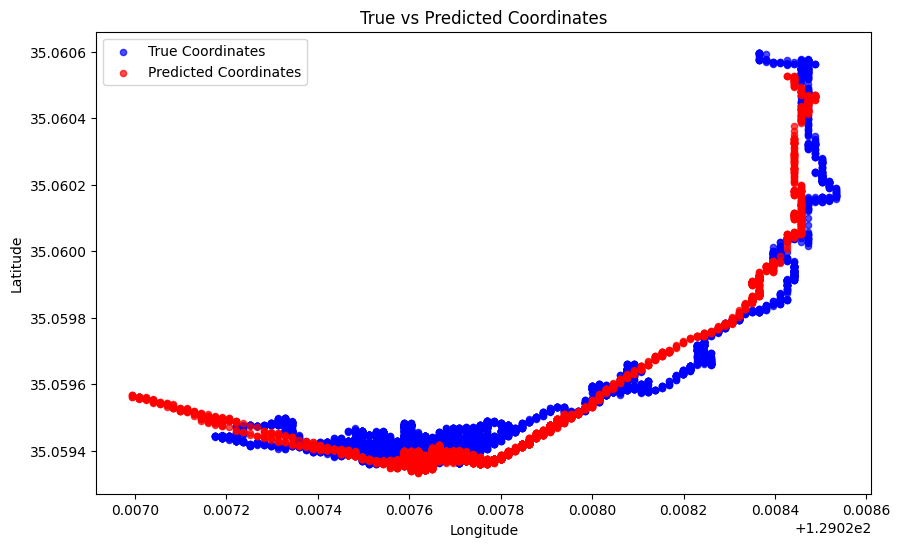

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison['True Lon'], comparison['True Lat'], label='True Coordinates', alpha=0.7, c='blue', s=20)
plt.scatter(comparison['Predicted Lon'], comparison['Predicted Lat'], label='Predicted Coordinates', alpha=0.7, c='red', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.show()


                lat           lon
count  3.682900e+04  3.682900e+04
mean   8.819881e-12  1.353385e-11
std    1.000014e+00  1.000014e+00
min   -1.393735e+00 -1.580520e+00
25%   -9.868269e-01 -1.130045e+00
50%   -1.178378e-01  1.478662e-01
75%    7.890834e-01  7.860397e-01
max    1.939115e+00  1.618168e+00


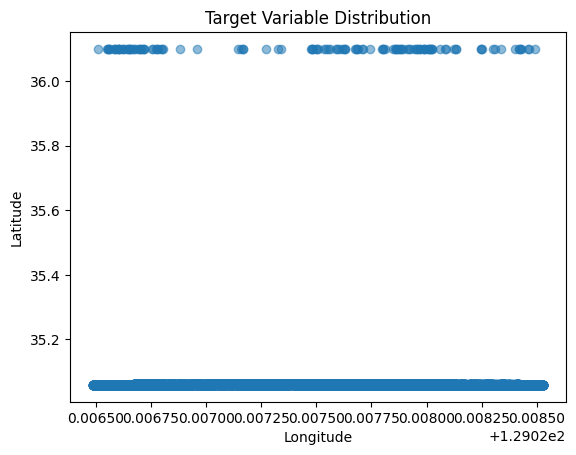

In [18]:
# 타겟 변수의 분포 확인
print(filtered_data[['lat', 'lon']].describe())

# 타겟 변수의 시각화
import matplotlib.pyplot as plt
plt.scatter(data['lon'], data['lat'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Target Variable Distribution')
plt.show()


In [13]:
# 원 데이터
print(f"원 데이터 (첫 5개):\n{data[target_columns].head().values}")

# 스케일링된 데이터
print(f"스케일링된 데이터 (첫 5개):\n{y[:5]}")

# 역스케일링된 데이터
y_inverse = scaler.inverse_transform(y[:5])
print(f"역스케일링된 데이터 (첫 5개):\n{y_inverse}")

원 데이터 (첫 5개):
[[2.19871459 0.20346102]
 [2.13926907 0.17730997]
 [2.00843444 0.07601129]
 [2.00449148 0.07312421]
 [1.91665664 0.00923198]]
스케일링된 데이터 (첫 5개):
[[ 1.9122046   0.00609386]
 [ 1.8718144  -0.02392754]
 [ 1.8550676  -0.03627083]
 [ 1.8437047  -0.04463917]
 [ 1.8305925  -0.05447196]]
역스케일링된 데이터 (첫 5개):
[[ 35.340137 129.4093  ]
 [ 35.334503 129.40787 ]
 [ 35.33217  129.40729 ]
 [ 35.33058  129.40688 ]
 [ 35.328754 129.40642 ]]
